In [1]:
"""
# Header ------------------------------------------------------------------

# Fitting a logistic regression in JAGS

# In this file we fit a Bayesian Generalised Linear Model (GLM) in the form
# of a logistic regression.
"""

import pyjags
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas.tools.plotting import *

"""
# Maths -------------------------------------------------------------------

# Description of the Bayesian model fitted in this file
# Notation:
# y_t = binomial (often binary) response variable for observation t=1,...,N
# x_{1t} = first explanatory variable for observation t
# x_{2t} = second explanatory variable for observation t
# p_t = probability of y_t being 1 for observation t
# alpha = intercept term
# beta_1 = parameter value for explanatory variable 1
# beta_2 = parameter value for explanatory variable 2

# Likelihood
# y_t ~ Binomial(K,p_t), or Binomial(1,p_t) if binary
# logit(p_t) = alpha + beta_1 * x_1[t] + beta_2 * x_2[t]
# where logit(p_i) = log( p_t / (1 - p_t ))
# Note that p_t has to be between 0 and 1, but logit(p_t) has no limits

# Priors - all vague
# alpha ~ normal(0,100)
# beta_1 ~ normal(0,100)
# beta_2 ~ normal(0,100)
"""

# Simulate data -----------------------------------------------------------

np.random.seed(123)

T = 100;
x_1 = np.random.uniform(0, 10, T)
x_2 = np.random.uniform(0, 10, T) 
alpha = 1
beta_1 = 0.2
beta_2 = -0.5
logit_p = alpha + beta_1 * x_1 + beta_2 * x_2
p =  np.exp(logit_p)/(1+np.exp(logit_p)) # inverse logit
y = np.random.binomial(1,p,T)


Text(0.5,0,'x_1')

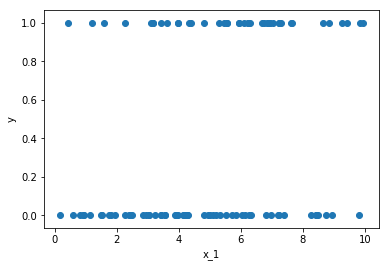

In [2]:
# Have a quick look at the effect of x_1 and x_2 on y
plt.scatter(x_1,y)
plt.ylabel('y')
plt.xlabel('x_1')

Text(0.5,0,'x_2')

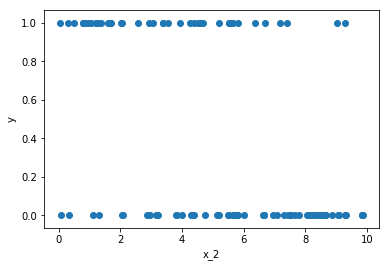

In [3]:
plt.scatter(x_2,y) # When x is high y tends to be 0
plt.ylabel('y')
plt.xlabel('x_2')

In [4]:
# Jags code ---------------------------------------------------------------

# Jags code to fit the model to the simulated data
code = """
model
{
  # Likelihood
  for (t in 1:T) {
  y[t] ~ dbin(p[t], K)
  logit(p[t]) <- alpha + beta_1 * x_1[t] + beta_2 * x_2[t]
  }
  
  # Priors
  alpha ~ dnorm(0.0,0.01)
  beta_1 ~ dnorm(0.0,0.01)
  beta_2 ~ dnorm(0.0,0.01)
}
"""

In [5]:
# Set up the data
model = pyjags.Model(code, data=dict(T = T, y = y, x_1 = x_1, x_2 = x_2, K = 1))

# Number of iterations to remove at start
model.sample(200, vars=[])

# Choose the parameters to watch and iterations:
samples = model.sample(1000, vars=['alpha', 'beta_1', 'beta_2'])

"""
Simulated results ----------------------------------------------------------------
"""
def summary(samples, varname, p=95):
    values = samples[varname]
    ci = np.percentile(values, [100-p, p])
    print('{:<6} mean = {:>5.1f}, {}% credible interval [{:>4.1f} {:>4.1f}]'.format(
      varname, np.mean(values), p, *ci))

for varname in ['alpha', 'beta_1', 'beta_2']:
    summary(samples, varname)




adapting: iterations 4000 of 4000, elapsed 0:00:01, remaining 0:00:00
sampling: iterations 800 of 800, elapsed 0:00:00, remaining 0:00:00
sampling: iterations 4000 of 4000, elapsed 0:00:01, remaining 0:00:00
alpha  mean =   0.3, 95% credible interval [-0.8  1.5]
beta_1 mean =   0.3, 95% credible interval [ 0.1  0.5]
beta_2 mean =  -0.4, 95% credible interval [-0.6 -0.3]


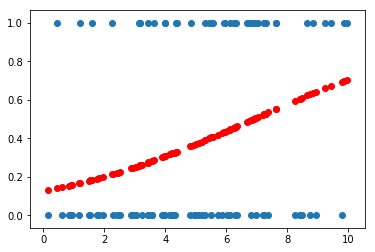

In [8]:
plt.scatter(x_1, y)
A = 0.281661 + 0.282083 * x_1 + -0.432326 * 5.142249 # i.e: alpha_mean + beta_1_mean * x_1 + beta_2_mean * mean(x_2)
zx = np.exp(A)/(1+np.exp(A)) # Inverse logit of A
plt.scatter(x_1, zx, c = 'red') # draws a curve based on prediction from logistic regression model

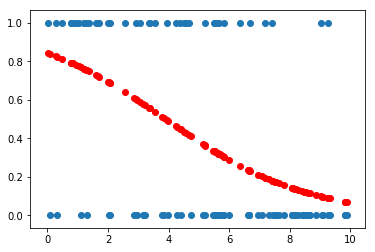

In [29]:
plt.scatter(x_2, y)
B = 0.281661 + 0.282083 * 4.98559 + -0.432326 * x_2 # i.e: alpha_mean + beta_1_mean * mean(x_1) + beta_2_mean * x_2
# Vaules were obtained from the pandas print out shown below
zy = np.exp(B)/(1+np.exp(B)) # Inverse logit of B
plt.scatter(x_2, zy, c = 'red')

 Line for x_1 should be increasing with x_1, and vice versa with x_2


/Users/alaninglis/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/alaninglis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.


Mean:
Variable
alpha     0.281661
beta_1    0.282083
beta_2   -0.432326
dtype: float64
Credible Intervals:
Variable     alpha    beta_1    beta_2
0.05     -0.691312  0.115127 -0.587916
0.95      1.337381  0.444549 -0.283115


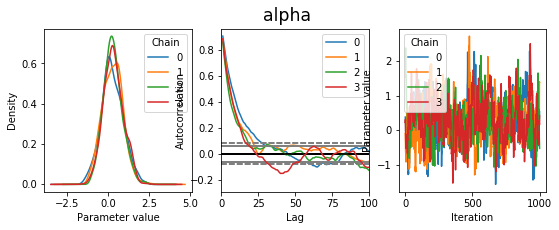

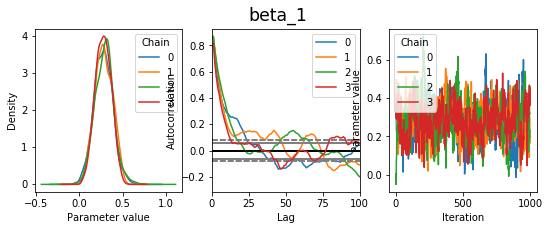

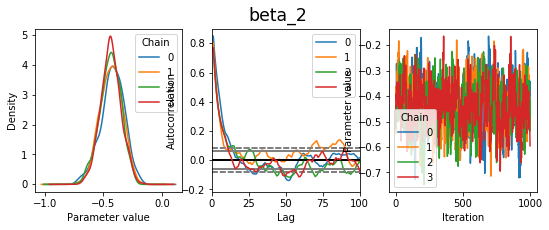

In [28]:
# Use pandas three dimensional Panel to represent the trace:
trace = pd.Panel({k: v.squeeze(0) for k, v in samples.items()})
trace.axes[0].name = 'Variable'
trace.axes[1].name = 'Iteration'
trace.axes[2].name = 'Chain'
 
# Point estimates:
print("Mean:")
print(trace.to_frame().mean())
 

# Bayesian equal-tailed 95% credible intervals:
print("Credible Intervals:")
print(trace.to_frame().quantile([0.05, 0.95]))
 

def plot(trace, var):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    fig.suptitle(var, fontsize='xx-large')
 
    # Marginal posterior density estimate:
    trace[var].plot.density(ax=axes[0])
    axes[0].set_xlabel('Parameter value')
    axes[0].locator_params(tight=True)
 
    # Autocorrelation for each chain:
    axes[1].set_xlim(0, 100)
    for chain in trace[var].columns:
        autocorrelation_plot(trace[var,:,chain], axes[1], label=chain)
 
    # Trace plot:
    axes[2].set_ylabel('Parameter value')
    trace[var].plot(ax=axes[2])
 
   
 # Display diagnostic plots
for var in trace:
    plot(trace, var)